In [2]:
from pydantic import BaseModel, Field

from qdrant_client import QdrantClient
from qdrant_client.models import Prefetch, Filter, FieldCondition, MatchText, FusionQuery, Document


from langsmith import traceable, get_current_run_tree

from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.types import Send, Command

from langchain_core.messages import AIMessage, ToolMessage

from jinja2 import Template
from typing import Literal, Dict, Any, Annotated, List, Optional, Sequence
from IPython.display import Image, display
from operator import add
from openai import OpenAI

import openai

import random
import ast
import inspect
import instructor
import json

from utils.utils import get_tool_descriptions, format_ai_message



/home/arminas_work/projects/AI-Engineering_Bootcamp/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Parallel Query Expansion

In [3]:
class RetrievalOutput(BaseModel):
    context_id: str
    context: str
    rating: float
    similarity_score: float


class State(BaseModel):
    expanded_query: List[str] = []
    retrieved_context: Annotated[List[RetrievalOutput], add] = []
    question_relevant: bool = False
    initial_query: str = ""
    answer: str = ""
    query:str = ""
    k:int = 5 

#### Query expansion

In [4]:
class QueryExpandResponse(BaseModel):
   expanded_query: List[str]

@traceable(
    name="query_expand_node",
    run_type="llm",
    metadata={"ls_provider":"openai", "ls_model_name":"gpt-4.1-mini"}
)
def query_expand_node(state: State) -> dict:

    prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

    <Exmaple>
    Question: Can you suggest me earphones, and parfumes for my girlfirend?

    Returned statements:
    -Earphones
    -Women parfume

    </Example>

    Instructions:
    - You will be given a question and you need to expand it into a list of statements that can be used in contextual search to retrieve relevant products.
    - The statements should not overlap in context.

    <Question>
    {{ query }}
    </Question>
    """

    template = Template(prompt_template)
    
    prompt = template.render(
        query=state.initial_query
    )

    client = instructor.from_openai(OpenAI())

    response, raw_response = client.chat.completions.create_with_completion(
            model="gpt-4.1-mini",
            response_model=QueryExpandResponse,
            messages=[{"role": "system", "content": prompt}],
            temperature=0,
    )

    return {
        "expanded_query": response.expanded_query
    }

In [5]:
def query_expand_conditional_edges(state: State):

    send_messages = []

    for query in state.expanded_query:
        send_messages.append(
            Send(
                "retriever_node",
                {
                    "query": query,
                    "k": 10
                }
            )
        )

    return send_messages

#### Retriever node

In [6]:
@traceable(
    name="embed_query",
    run_type="embedding",
    metadata={"ls_provider": "openai", "ls_model_name": "text-embedding-3-small"}
)
def get_embedding(text:str, model:str ="text-embedding-3-small"):
    response = openai.embeddings.create(
        input=[text],
        model=model,
    )
    return response.data[0].embedding

@traceable(
    name="retrieve_top_n",
    run_type="retriever"
)
def retriever_node(state: State)-> list[RetrievalOutput]:

    qdrant_client = QdrantClient(url="http://localhost:6333")

    query_embedding = get_embedding(state['query'])
    results = qdrant_client.query_points(
        collection_name="Amazon-items-collection-01-hybrid-search",
        prefetch=[
            Prefetch(
                query=query_embedding,
                using="text-embedding-3-small",
                limit=20
            ),
            Prefetch(
                query=Document(
                    text=state["query"],
                    model="qdrant/bm25"
                ),
                using="bm25",
                limit=20
            )
        ],
        query=FusionQuery(fusion="rrf"),
        limit=state["k"],
    )

    retrieval_outputs = []

    for result in results.points:
        retrieval_output= RetrievalOutput(
            context_id= result.payload["parent_asin"],
            context= result.payload["description"],
            rating = result.payload["average_rating"],
            similarity_score = result.score
        )
        retrieval_outputs.append(retrieval_output)

    return {
        "retrieved_context": retrieval_outputs
    }

#### Aggregator

In [7]:
class AggregatorResponse(BaseModel):
    answer: str = Field(description="Answer to the question.")

@traceable(
    name="aggregator_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def aggregator_node(state: State) -> dict:

   preprocessed_context = json.dumps([obj.model_dump(exclude={'similarity_score'}) for obj in state.retrieved_context])

   prompt_template =  """You are a shopping assistant that can answer questions about the products in stock.

You will be given a question and a list of context.

Instructions:
- You need to answer the question based on the provided context only.
- Never use word context and refer to it as the available products.
- The answer to the question should contain detailed information about the product and returned with detailed specification in bullet points.

Context:
{{ preprocessed_context }}

Question:
{{ question }}
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      preprocessed_context=preprocessed_context,
      question=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=AggregatorResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0.5,
   )

   return {
      "answer": response.answer
   }

#### User intent router node

In [8]:
class IntentRouterResponse(BaseModel):
    question_relevant: bool
    answer: str

In [9]:
@traceable(
    name="agent_node",
    run_type="llm",
    metadata={"ls_provider": "openai", "ls_model_name": "gpt-4.1-mini"}
)
def intent_router_node(state: State):

   prompt_template =  """You are part of a shopping assistant that can answer questions about products in stock.

Instructions:
- You will be given a question and you need to clasify it into relevant or not relevant.
- If the question is not relevant, return False in field "question_relevant" and set "answer" to explanation why it is not relevant.
- If the question is relevant, return True in field "question_relevant" and set "answer" to "".
- You should only answer questions about the products in stock. If the question is not about the products in stock, you should ask for clarification.

<Question>
{{ query }}
</Question>
"""

   template = Template(prompt_template)
   
   prompt = template.render(
      query=state.initial_query
   )

   client = instructor.from_openai(OpenAI())

   response, raw_response = client.chat.completions.create_with_completion(
        model="gpt-4.1-mini",
        response_model=IntentRouterResponse,
        messages=[{"role": "system", "content": prompt}],
        temperature=0,
   )

   return {
      "question_relevant": response.question_relevant,
      "answer": response.answer
      }

In [10]:
def intent_router_conditional_edges(state: State):

    if state.question_relevant:
        return "query_expand_node"
    else:
        return "end"

#### Graph

In [11]:

workflow = StateGraph(State)

workflow.add_node("intent_router_node", intent_router_node)
workflow.add_node("query_expand_node", query_expand_node)
workflow.add_node("retriever_node", retriever_node)
workflow.add_node("aggregator_node", aggregator_node)

workflow.add_edge(START, "intent_router_node")
workflow.add_conditional_edges(
    "intent_router_node",
    intent_router_conditional_edges,
    {
        "query_expand_node": "query_expand_node",
        "end": END
    }
)
workflow.add_conditional_edges(
    "query_expand_node", query_expand_conditional_edges
)
workflow.add_edge("retriever_node", "aggregator_node")
workflow.add_edge("aggregator_node", END)

graph = workflow.compile()

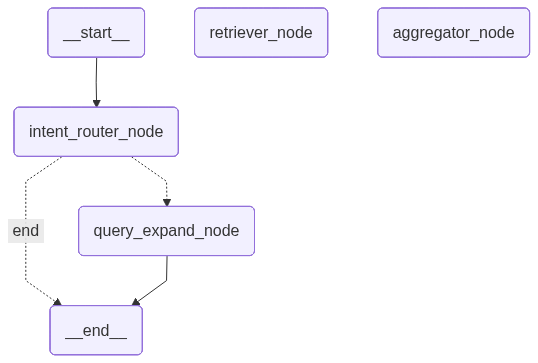

In [12]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
initial_state = {
    "initial_query": "Can I get a tablet for my kid, a watch for me a laptop for my wife and a waterproof speaker for our party next week?"
}
result = graph.invoke(initial_state)

In [14]:
result

{'expanded_query': ['tablet for kids',
  'watch for men',
  'laptop for women',
  'waterproof speaker for party'],
 'retrieved_context': [RetrievalOutput(context_id='B0C3XYD574', context='ROWT Tablet for Kids 10 inch Kids Tablet 2GB RAM 32GB ROM Android 11 6000mAh Wi-Fi, Bluetooth, Kid-Proof Case(Blue)【Kids\' Safety & Parental Controls】Looking for a safe tablet that\'s easy for your kids to use? This 10-inch tablet for kids is GMS-certified, has password protection, a content filter, and a one-button lock screen, making it easier for parents to keep an eye on their kids activities and learning. 【Creative Educational Content】Our kids tablet provides access to a range of age-appropriate creative kids content such as drawing, educational games, eBooks, learning videos, math tools, and much more! Learning through play is best for kids to understand the world. 【Powerful Configuration & Full Access to Google】This Android 11 kids tablet has an HD 1280x800 IPS touchscreen, 1.6 GHz Quad-Core pr

In [15]:
print(result['answer'])

For your kid, you can get the ROWT Tablet for Kids 10 inch which is designed specifically for children with safety and parental controls, educational content, and a durable kid-proof case. It features:
- 10.1 inch HD 1280x800 IPS touchscreen
- 2GB RAM, 32GB ROM storage
- Android 11 OS with full Google Play access
- 6000mAh battery
- Kid-proof case with built-in stand
- Creative educational apps and content

For you, a smart watch option is the AMAZTIM Smart Watch for MenWomen, a rugged military sports watch with:
- 1.71 inch high brightness screen (280x320 resolution)
- 5ATM waterproof rating
- Heart rate, blood pressure, blood oxygen monitoring
- 24 sports modes
- 10 days use time with 50 days standby
- Compatible with Android and iOS

For your wife, the Lenovo Newest Ideapad 15.6" Laptop is a good choice:
- 15.6 inch HD IPS display (1366 x 768)
- AMD Athlon Silver 3050U processor
- 4GB DDR4 RAM, 128GB eMMC storage
- Windows 11 Home in S Mode
- WiFi 6 and Bluetooth 5.0
- Lightweight a

In [16]:
initial_state = {
    "initial_query": "Whats the weather today?"
}
result = graph.invoke(initial_state)

In [17]:
result

{'retrieved_context': [],
 'question_relevant': False,
 'initial_query': 'Whats the weather today?',
 'answer': 'The question about the weather today is not relevant to the products in stock. Please ask about the products or specify your inquiry related to shopping.'}